In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from scipy.integrate import trapz
from scipy.optimize import curve_fit
from scipy.signal import medfilt

# from astropy.io import ascii
from astropy.io import fits


%matplotlib inline

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

In [46]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458 # speed of light m/s
# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + 1

# Reduced and order-merged data filepath 
# Desktop path
# data_path = "A:\\Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged"

# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"
# File path for figures to live in
# Desktop path
# fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra"

# Laptop Path
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt') # csv of standards with file and Spectral Type, c/v TBA

standard_shift = standard_table['Wavelength Shift']
standard_list = standard_table['Source']

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

# Initialize flux_stack with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(standard_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    median_flux = medfilt(flux, kernel_size=101)
    norm_flux = flux/median_flux

    snr = fits.getdata(file)[2]
    # Clean data a bit
    snr_min = 10 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    flux_min = 0 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.3
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    # snr_cut & 
    mask = flux_cut & wavelen_cut
    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]
    norm_flux = norm_flux[mask]

    # Remove NaNs and infs from wavelen and norm_flux arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isinf(wavelen) & ~np.isnan(norm_flux) & ~np.isinf(norm_flux) & ~np.isnan(flux) & ~np.isinf(flux) & ~np.isnan(snr) & ~np.isinf(snr)
    
    wavelen = wavelen[valid_indices] - standard_shift[i]
    flux = flux[valid_indices]
    norm_flux = norm_flux[valid_indices]
    snr = snr[valid_indices]

    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux
    snr_stack[:len(snr),i] = snr
    flux_stack[:len(norm_flux), i] = norm_flux  # Normalized flux arrays for each standard

# Determine the maximum length of flux arrays for the protostars
max_flux_length = max(len(fits.getdata(file)[1]) for file in hops_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in hops_list)

# Initialize flux_stack with NaN values
hops_wavelen_stack = np.full((max_wavelen_length, len(hops_list)), np.nan)
hops_raw_flux_stack = np.full((max_flux_length, len(hops_list)), np.nan)
hops_flux_stack = np.full((max_flux_length, len(hops_list)), np.nan)
hops_snr_stack = np.full((max_snr_length, len(hops_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(hops_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    snr = fits.getdata(file)[2] # snr per resolution element I think

    median_flux = medfilt(flux, kernel_size=101)
    norm_flux = flux/median_flux

    # Remove NaNs and infs from wavelen and norm_flux arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isinf(wavelen) & ~np.isnan(norm_flux) & ~np.isinf(norm_flux) & ~np.isnan(flux) & ~np.isinf(flux) & ~np.isnan(snr) & ~np.isinf(snr)
    
    wavelen = wavelen[valid_indices]
    flux = flux[valid_indices]
    norm_flux = norm_flux[valid_indices]
    snr = snr[valid_indices]
    
    # Clean data a bit
    snr_min = 5 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    flux_min = 0 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.35
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    mask = flux_cut & wavelen_cut & snr_cut

    wavelen = wavelen[mask]
    flux = flux[mask]
    norm_flux = norm_flux[mask]
    snr = snr[mask]



    hops_wavelen_stack[:len(wavelen),i] = wavelen # wavelength arrays for each protostar
    hops_raw_flux_stack[:len(flux),i] = flux
    hops_snr_stack[:len(snr),i] = snr # snr arrays for each protostar
    hops_flux_stack[:len(norm_flux),i] = norm_flux # normalized flux arrays for each protostar

    

# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.2*u.um,2.3*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')
igrins_wav_cut = (lines_table['Observed'] > 2.2) & (lines_table['Observed'] < 2.45)

lines_table = lines_table[igrins_wav_cut]
# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

C:\Users\Savio\AppData\Local\Temp\ipykernel_66308\4181206040.py:55: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux
C:\Users\Savio\AppData\Local\Temp\ipykernel_66308\4181206040.py:110: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux


In [47]:
# Initialize an empty list to store vel_over_c values for each source
vel_over_c_list = []
wavelen_shift_list = []

# Loop through each source in standard_table
for protostar in range(len(hops_table)):
    # Calculate the minimum flux within the specified wavelength range for the current source
    min_flux = np.nanmin(hops_flux_stack[:, protostar][(hops_wavelen_stack[:, protostar] > 2.206) & (hops_wavelen_stack[:, protostar] < 2.207)])
    
    # Find the index where the minimum flux occurs for the current source
    min_flux_index = np.where(hops_flux_stack[:, protostar] == min_flux)[0][0]  # Assuming min_flux_index is a scalar
    
    # Get the wavelength corresponding to the minimum flux for the current source
    min_flux_wavelength = hops_wavelen_stack[min_flux_index, protostar]
    
    # Calculate the wavelength shift for the current source
    wavelen_shift = min_flux_wavelength - lines_table[na1_mask]['Observed'][0]
    
    # Calculate vel_over_c for the current source
    vel_over_c = wavelen_shift / lines_table[na1_mask]['Observed'][0]
    
    # Append vel_over_c  and wavelen_shift to the list
    wavelen_shift_list.append(wavelen_shift)
    vel_over_c_list.append(vel_over_c)

# Convert the list to a NumPy array if needed
vel_over_c_array = np.array(vel_over_c_list)
wavelen_shift_array = np.array(wavelen_shift_list)
vel_over_c_array, wavelen_shift_array

(array([5.80694594e-05, 3.53757106e-05, 3.53757106e-05, 2.30217753e-04,
        2.30217753e-04, 1.26042640e-04, 8.51938924e-05, 1.66783322e-04,
        9.88101416e-05, 4.89919599e-05]),
 array([1.28115280e-04, 7.80473785e-05, 7.80473785e-05, 5.07916077e-04,
        5.07916077e-04, 2.78080566e-04, 1.87958344e-04, 3.67964371e-04,
        2.17999084e-04, 1.08088120e-04]))

In [48]:
hops_table[r'v/c'] = vel_over_c_array
hops_table['Wavelength_Shift'] = wavelen_shift_array

In [74]:
hops_raw_flux_stack[:,0]

array([306202., 305006., 312452., ...,     nan,     nan,     nan])

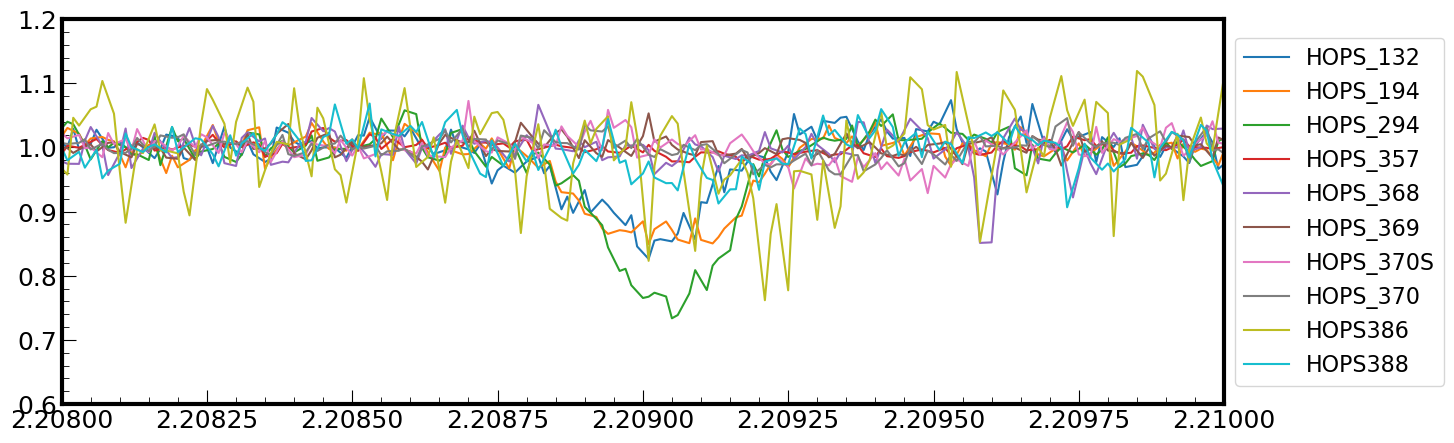

In [ ]:
fig = plt.figure(figsize=(15,5))
flux_const = np.linspace(0,5,len(hops_list))
for i in range(len(hops_list)):
    
    plt.plot(hops_wavelen_stack[:,i],hops_flux_stack[:,i],label=f"{hops_table['Name'][i]}")
    # plt.ylim(bottom=-0.1e6,top=0.75e6)
    # plt.ylim(0.6,1.2)
    plt.xlim(2.1,2.13)

plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.show()

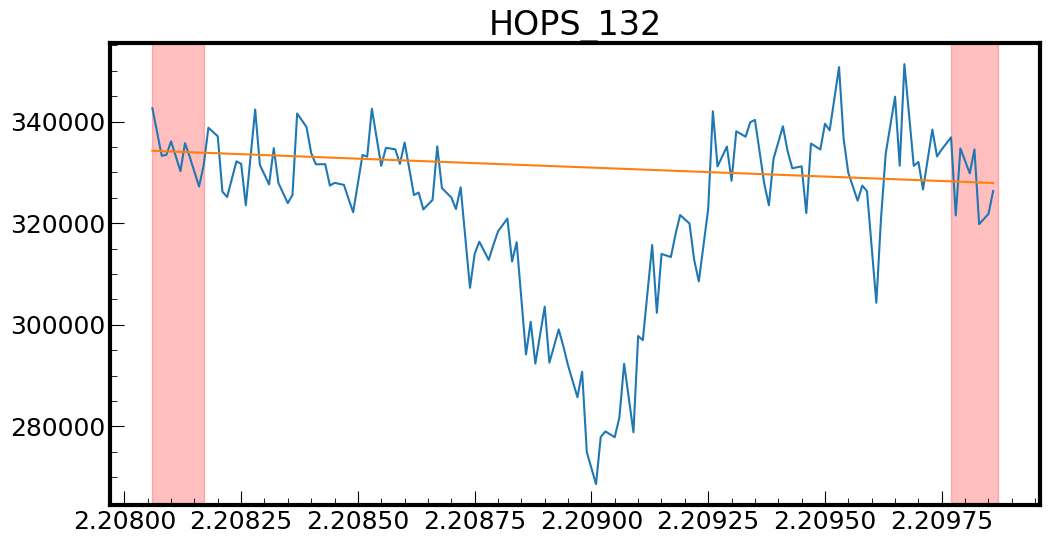

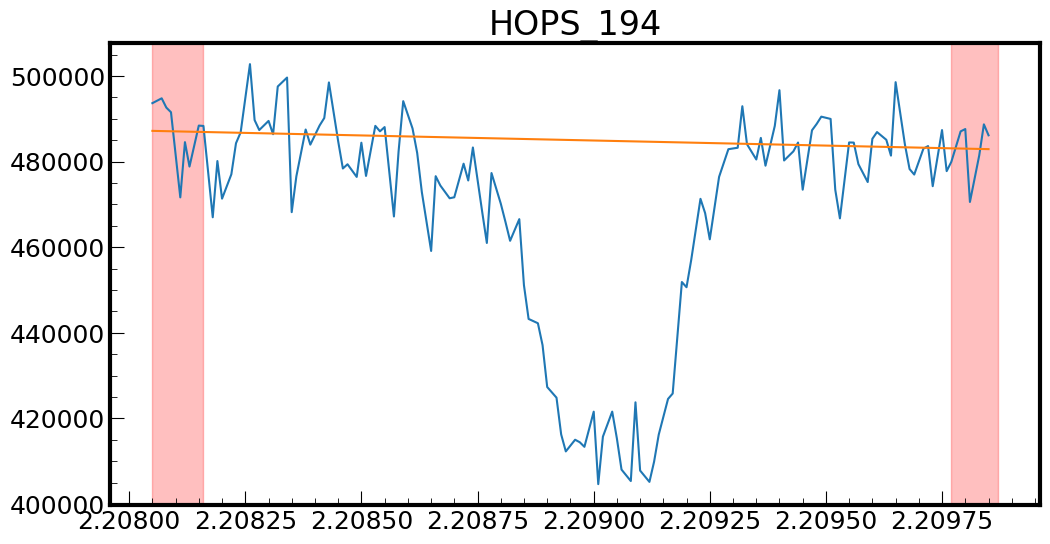

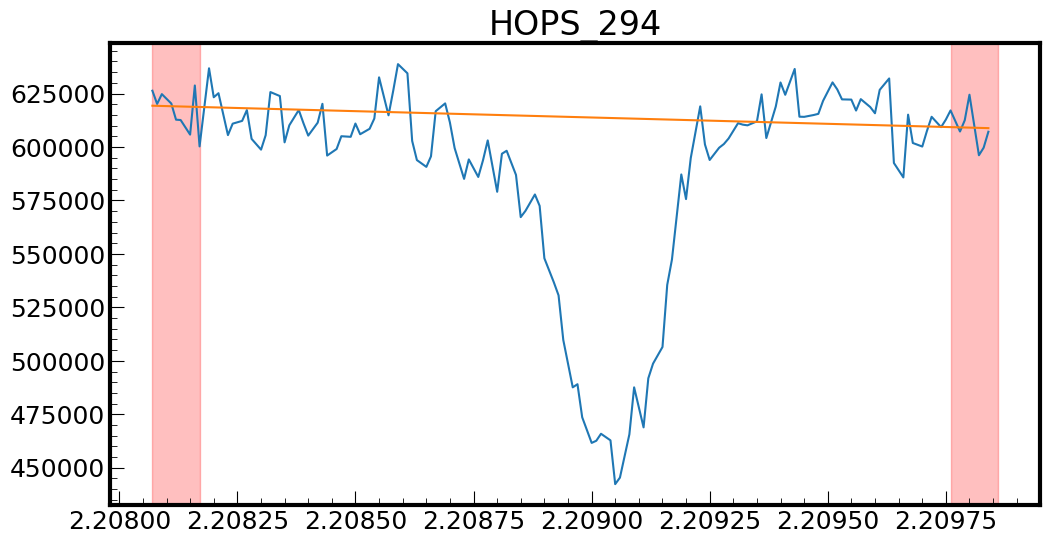

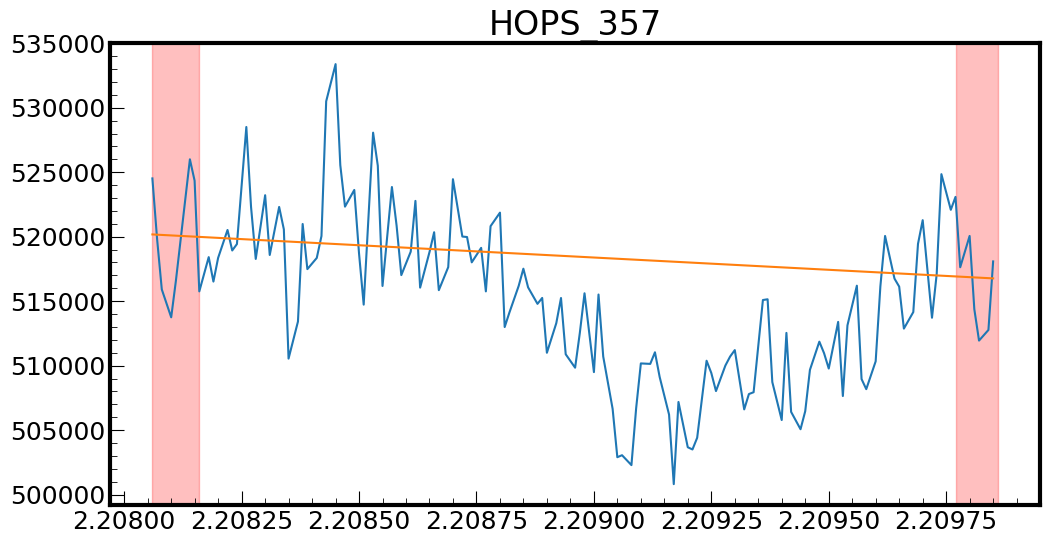

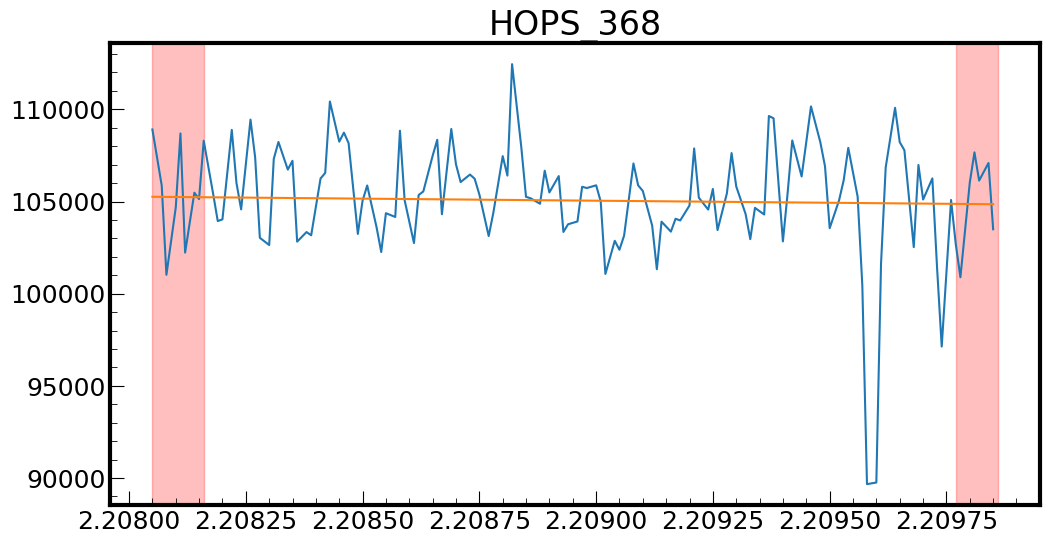

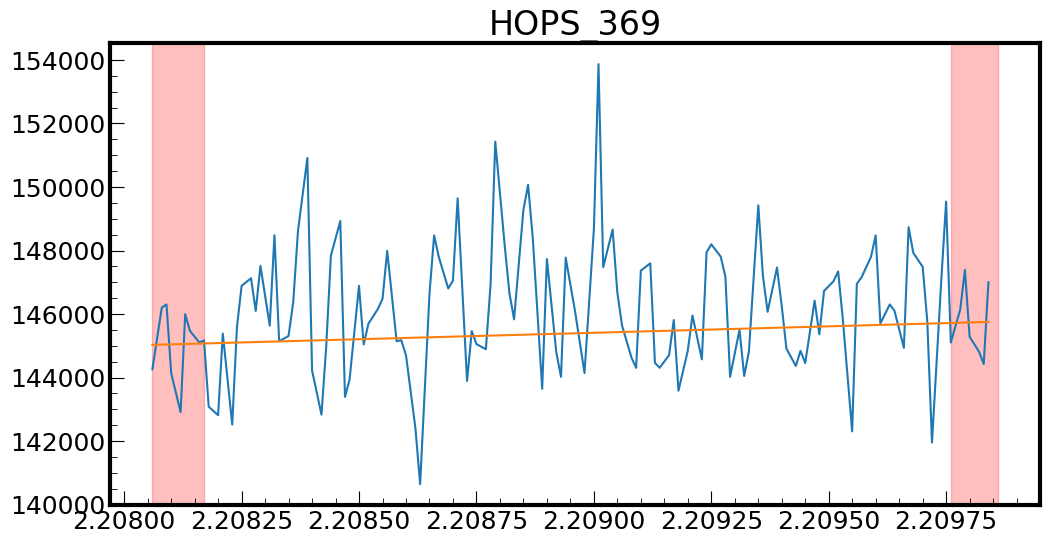

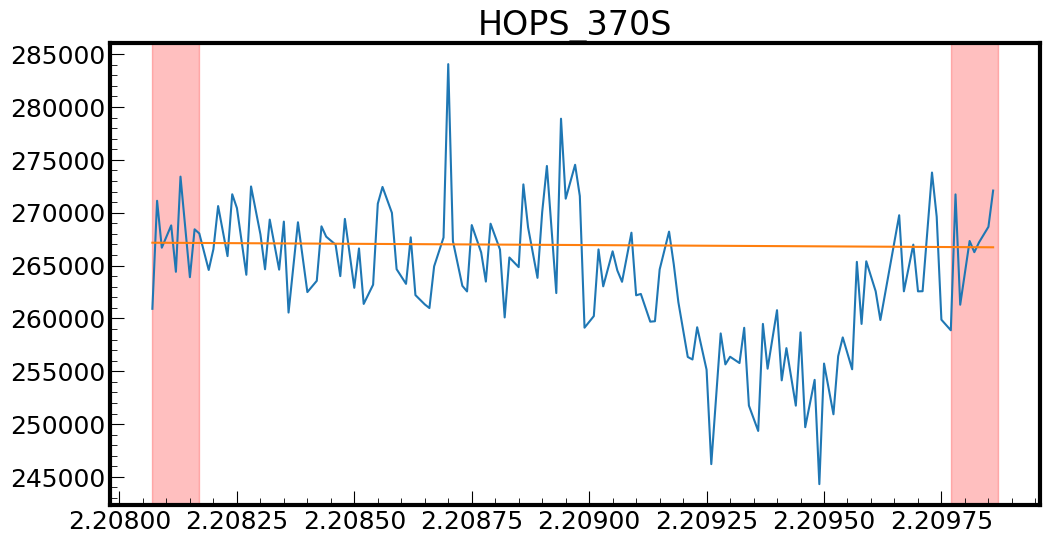

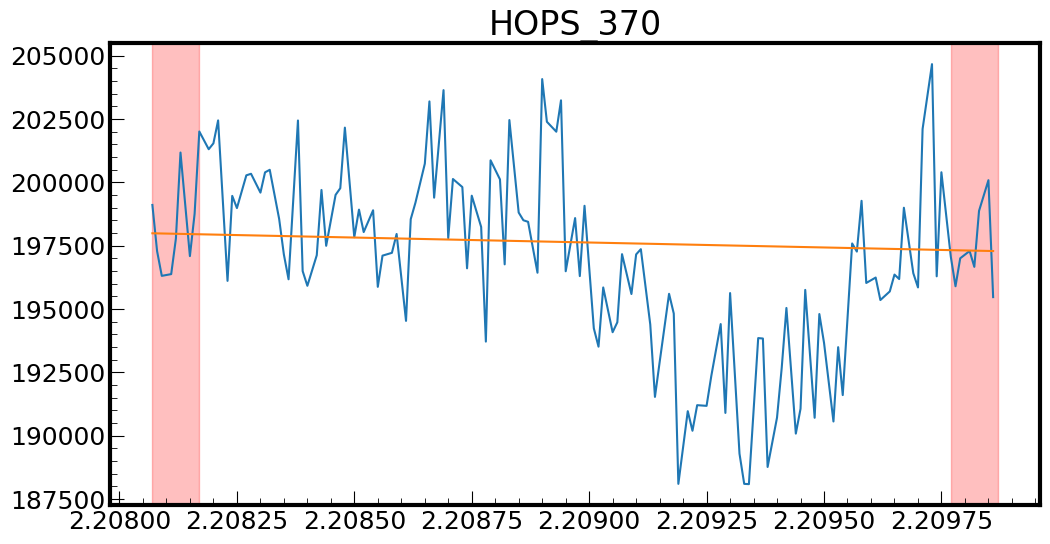

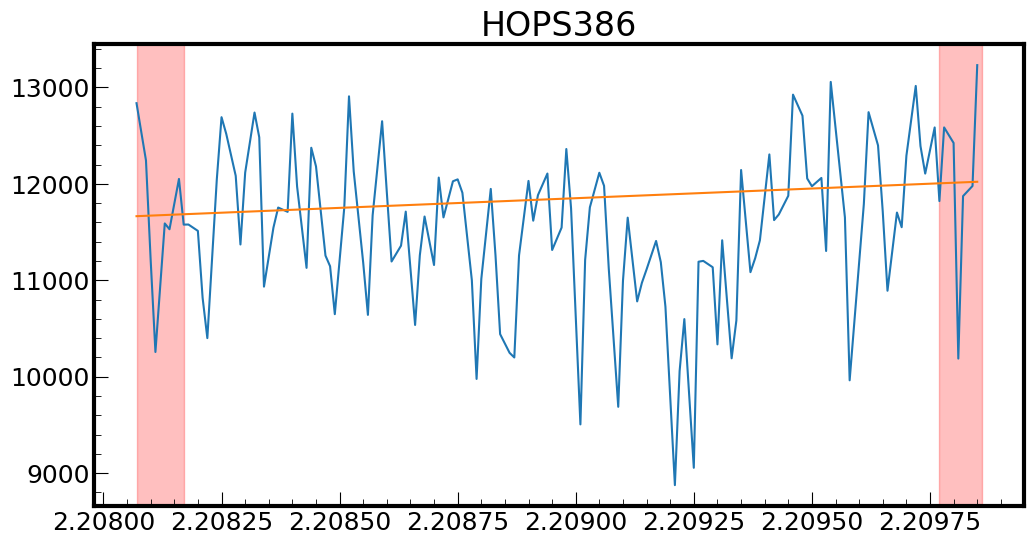

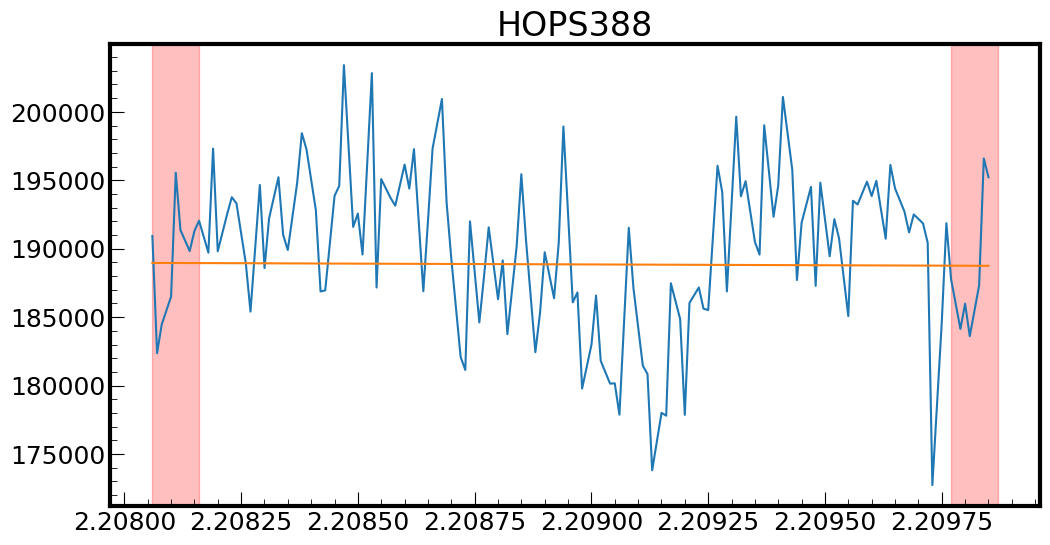

In [50]:
# Define the region for fitting
line_name = lines_table[na1_mask][0]['Spectrum'] # Species
line_center = lines_table[na1_mask][1]['Observed'] # Wavelength

idx1_stack = []
idx2_stack = []
idx3_stack = []
idx4_stack = []

normalized_flux_stack = []
continuum_stack = []

for i in range(len(hops_list)):
    continuum, idx1, idx2, idx3, idx4 = ig.local_continuum_fit(hops_wavelen_stack[:,i],
                                                               hops_raw_flux_stack[:,i],
                                                               1,
                                                               line_center,
                                                               spec_res,
                                                               window_size=10,
                                                               left_num=80,
                                                               right_num = 80)

    continuum_stack.append(continuum)

    normalized_flux_stack.append(hops_raw_flux_stack[idx1:idx4,i]/continuum)

    idx1_stack.append(idx1)
    idx2_stack.append(idx2)
    idx3_stack.append(idx3)
    idx4_stack.append(idx4)

    fig = plt.figure(figsize=(12,6))

    plt.plot(hops_wavelen_stack[idx1:idx4,i],hops_raw_flux_stack[idx1:idx4,i])
    plt.plot(hops_wavelen_stack[idx1:idx4,i],continuum)

    plt.axvspan(hops_wavelen_stack[idx1_stack[i],i],hops_wavelen_stack[idx2_stack[i],i],alpha=0.25,color='red')
    plt.axvspan(hops_wavelen_stack[idx3_stack[i],i],hops_wavelen_stack[idx4_stack[i],i],alpha=0.25,color='red')

    plt.title(f"{hops_table['Name'][i]}")
    plt.show()

c:\Users\Savio\anaconda3\envs\muler_dev\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


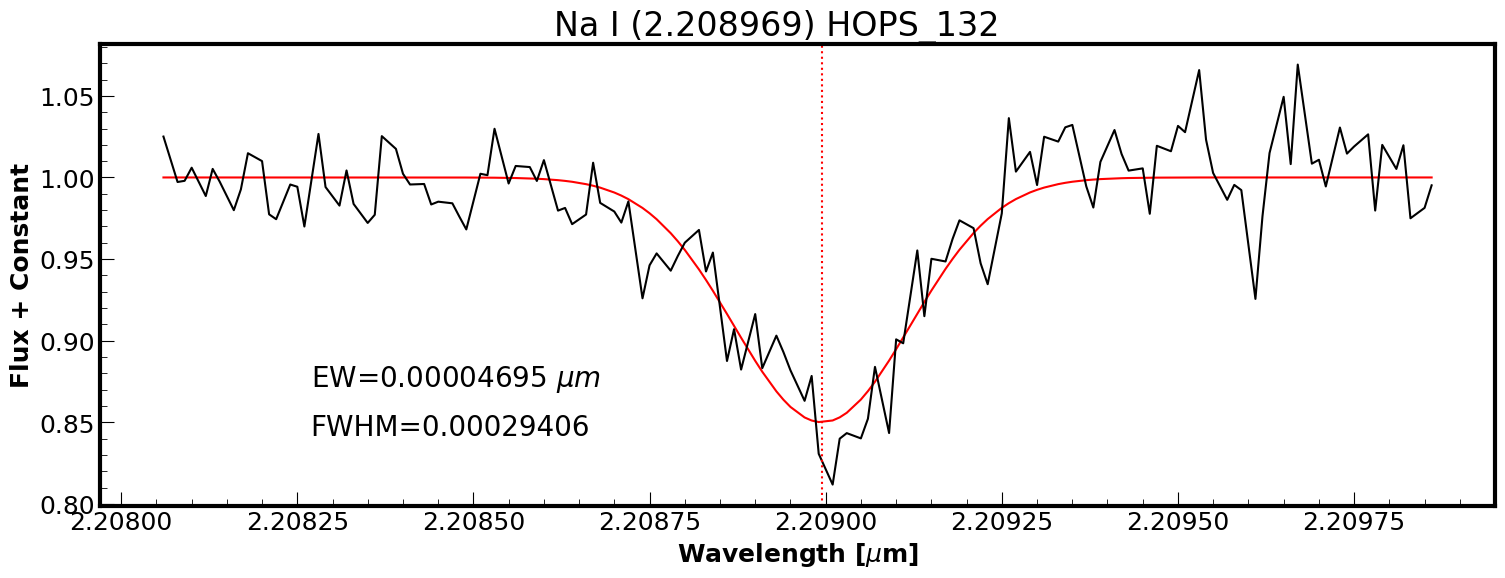

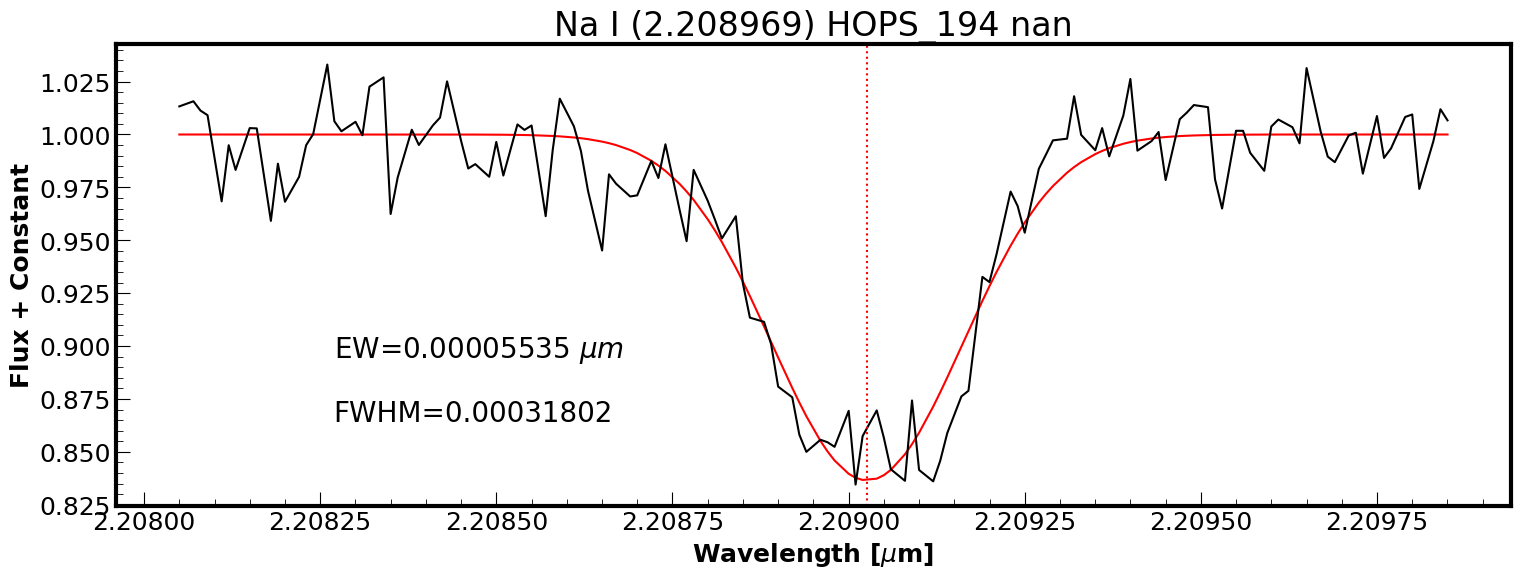

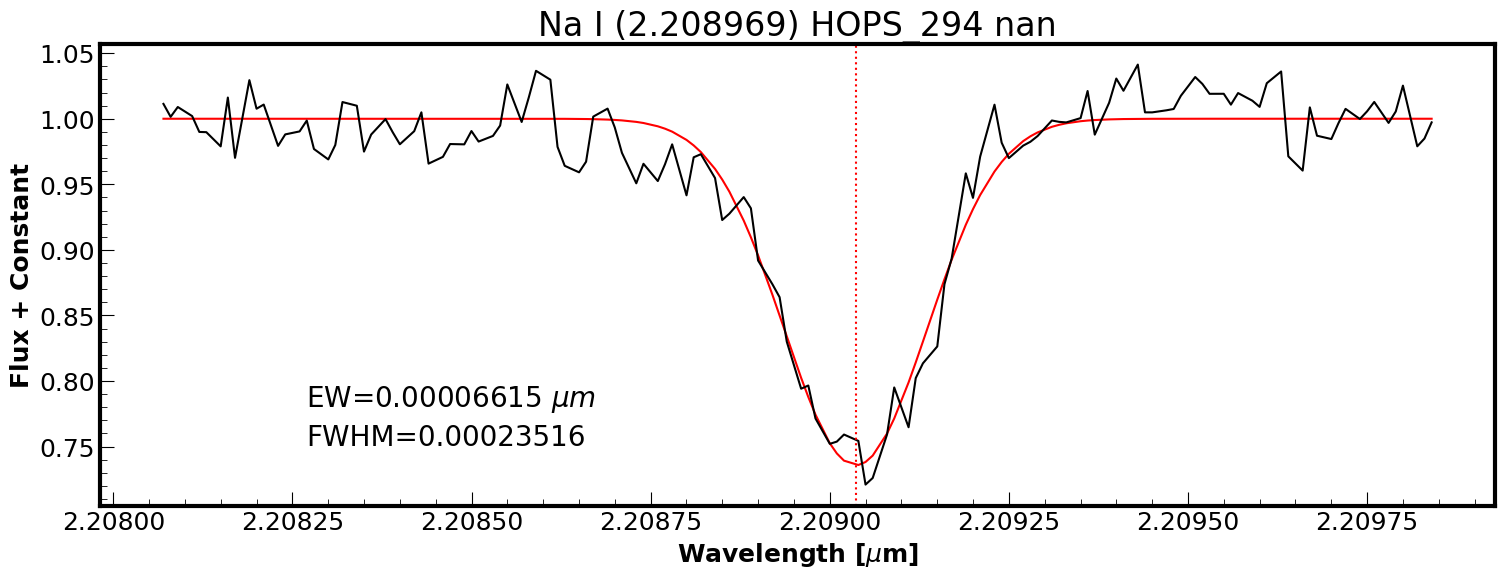

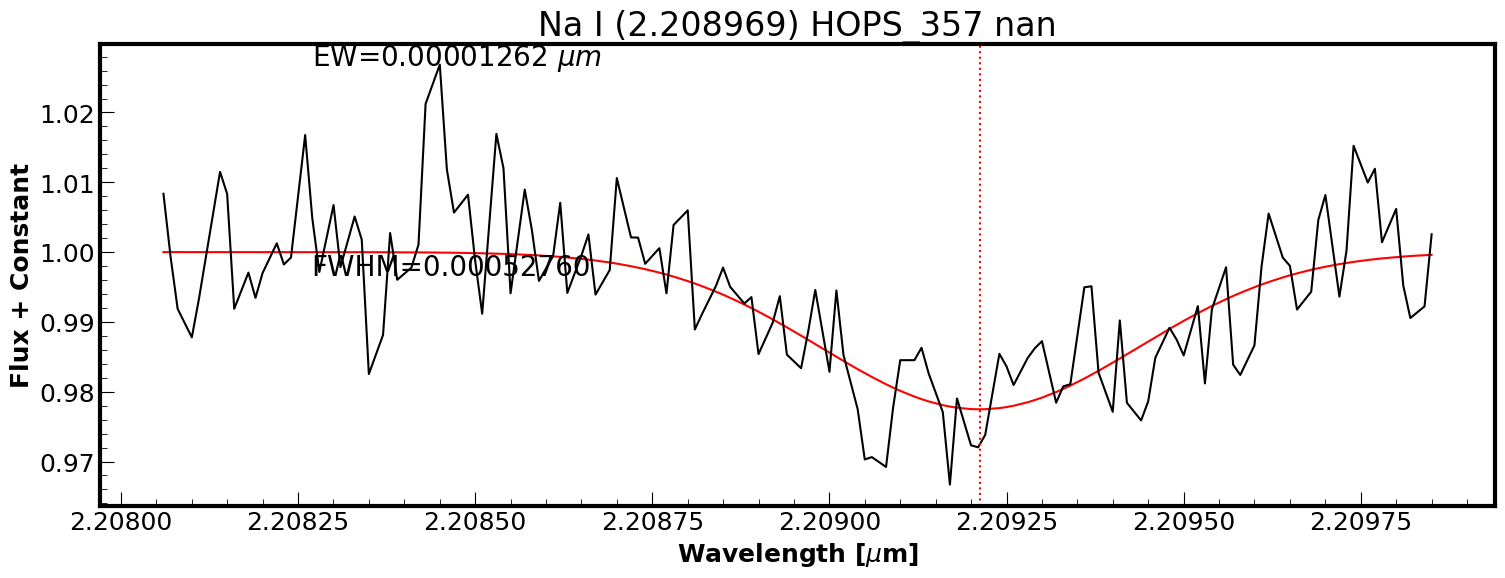

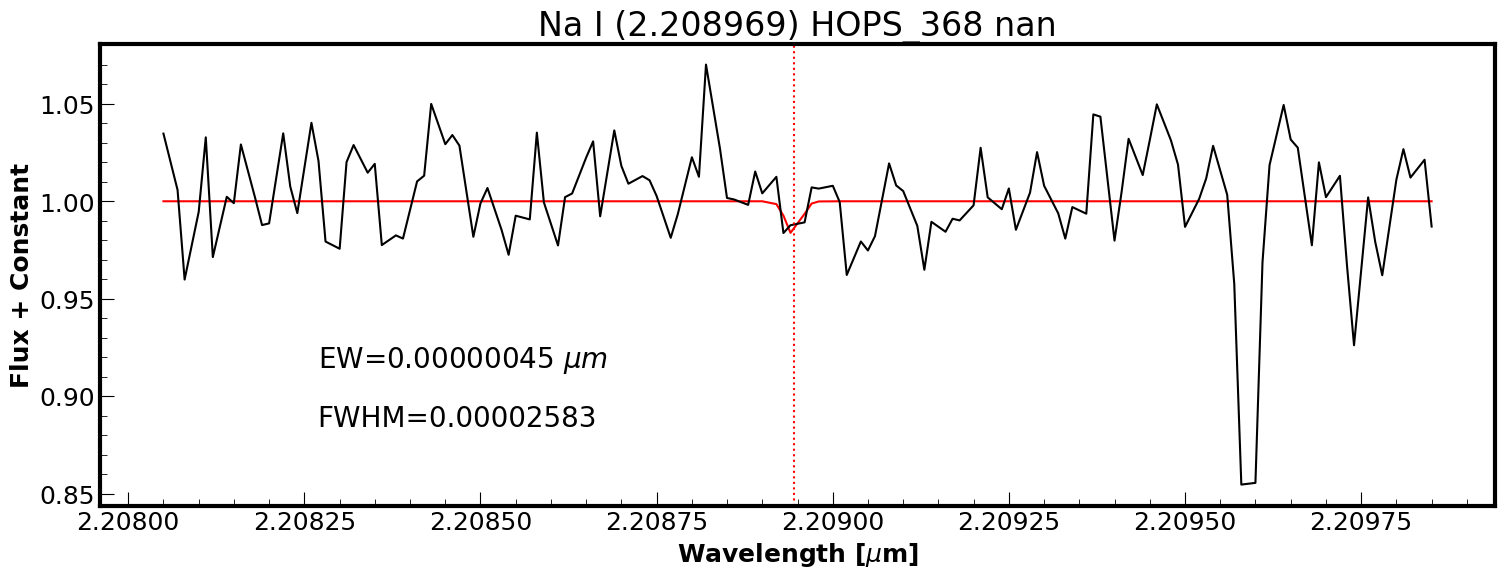

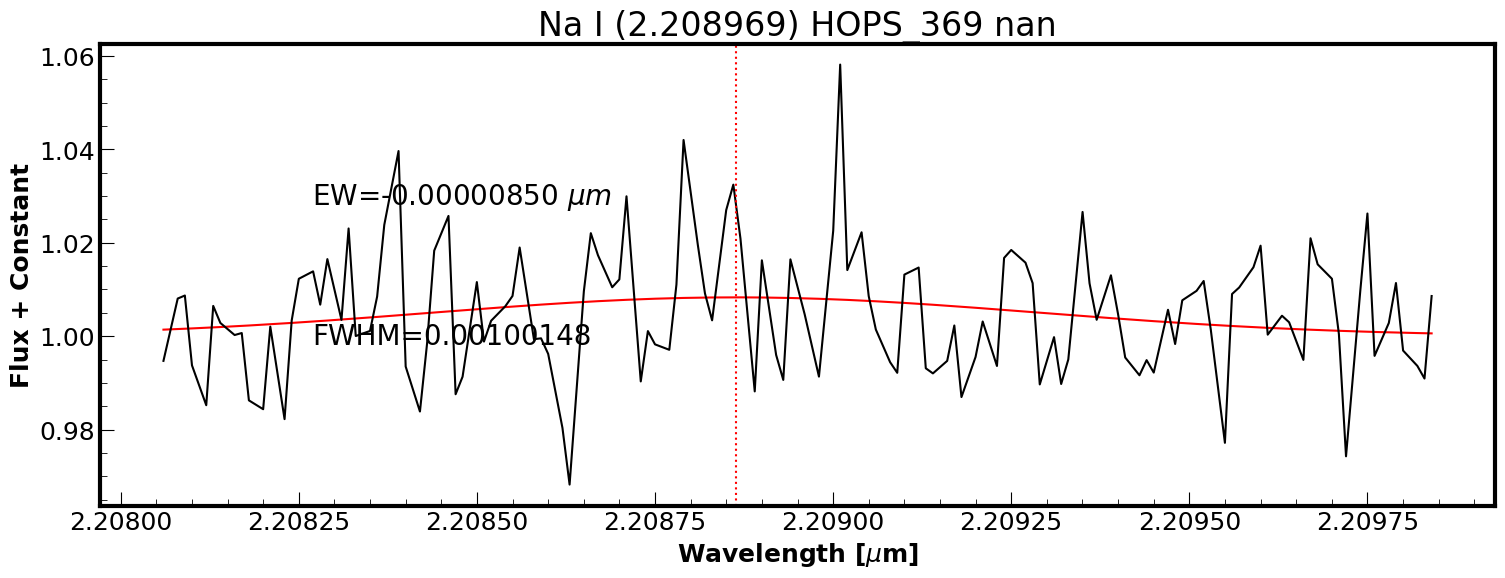

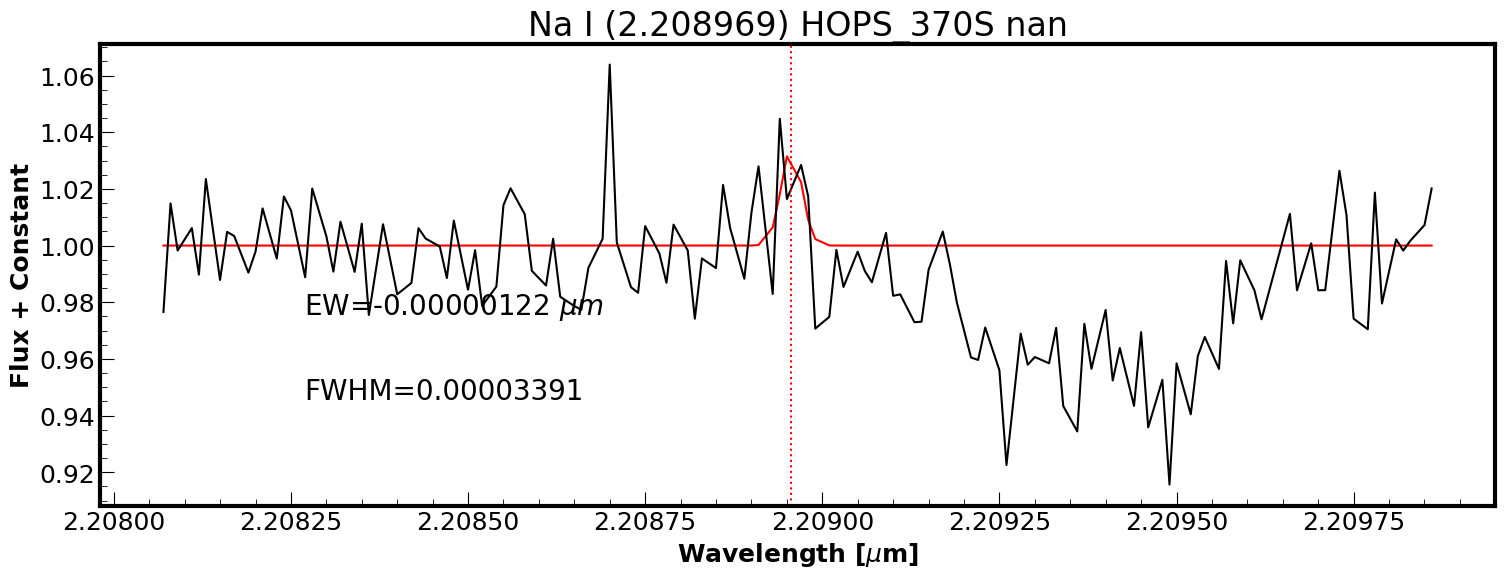

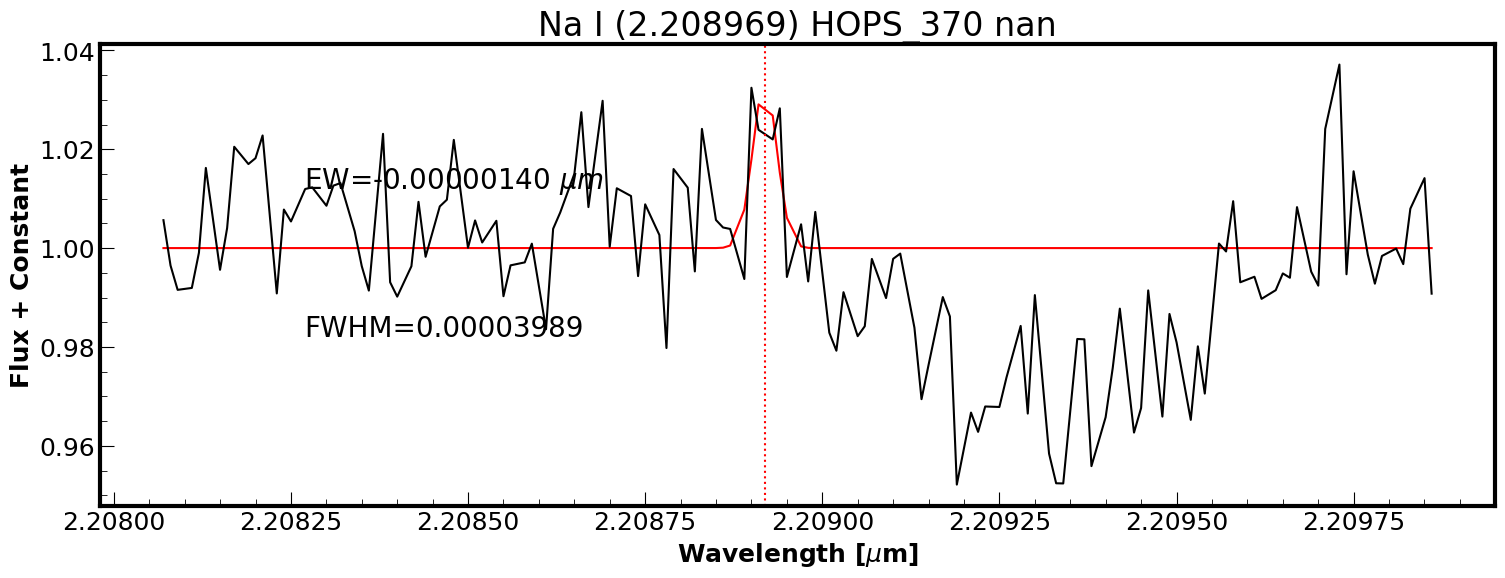

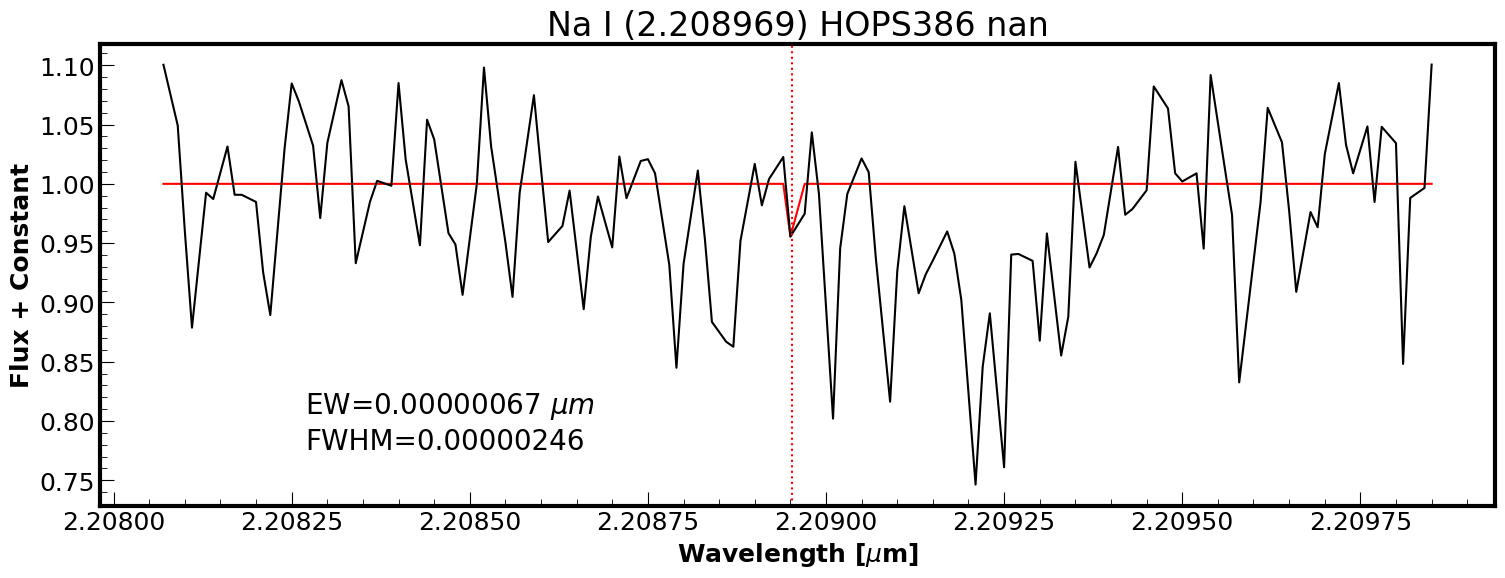

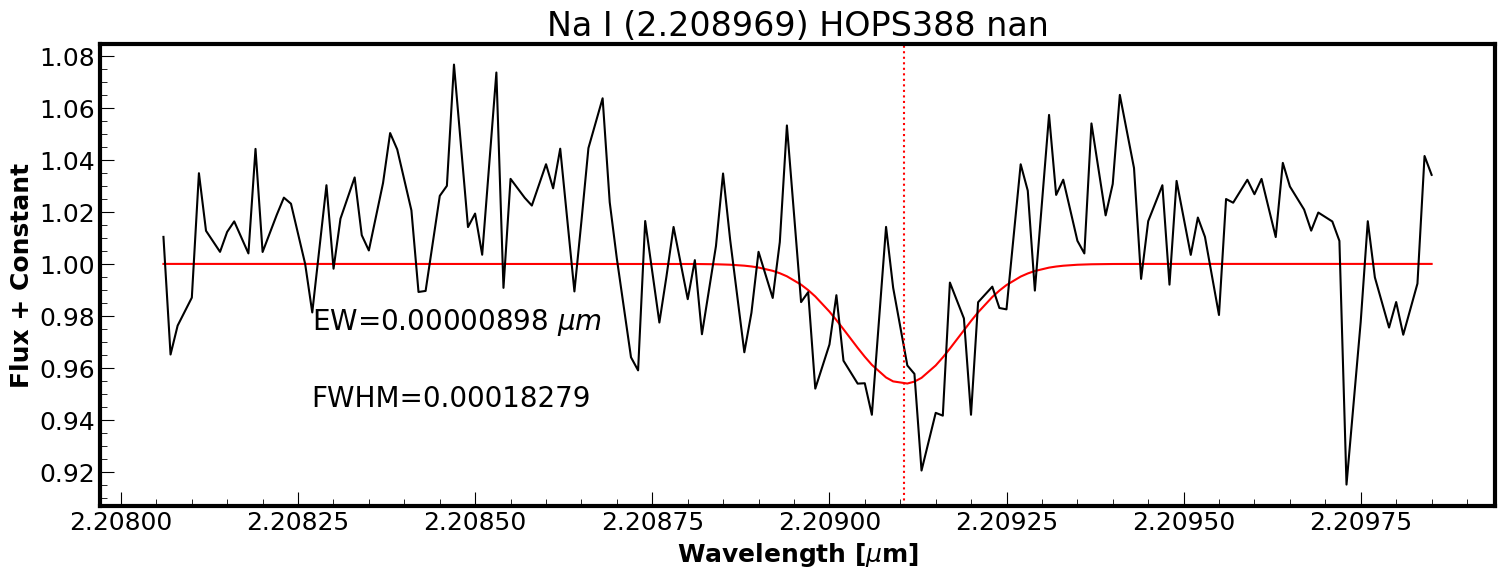

In [51]:
min_wave = line_center - (70 * spec_res)
max_wave = line_center + (70 * spec_res)

amplitude_stack = []
center_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(hops_list))

for i in range(len(hops_list)):
    # Define initial parameters for Gaussian fitting
    init_params = (-0.2, line_center, spec_res)#,(-0.2, lines_table[sc1_mask][1]['Observed'], 0.5)]#,0,1.0)
    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(hops_wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
                                        normalized_flux_stack[i],
                                        init_params,
                                        50000)

    amplitude_stack.append(popt[0])
    center_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)
    
for i in range(len(hops_list)):
    fwhm = 2*np.sqrt(2*np.log(2))*sigma_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    ew = np.trapz(1-best_model_stack[i],hops_wavelen_stack[idx1_stack[i]:idx4_stack[i],i])
    
    fig = plt.figure(figsize=(18,6))
    plt.plot(hops_wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             best_model_stack[i],c='red',label='Gaussian Fit')
    
    plt.plot(hops_wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             normalized_flux_stack[i],
             c='black')
    plt.axvline(center_stack[i],color='red',linestyle=':')
    # plt.axvspan(center_stack[i]-fwhm/2,center_stack[i]+fwhm/2,facecolor='red',alpha=0.2)

    # plt.ylim(top=1.05)
    # plt.xlim(min_wave,max_wave)

    plt.text(min_wave,np.nanmin(normalized_flux_stack[i])+0.03,f'FWHM={fwhm:.8f}')
    # plt.text(2.208,np.nanmax(1-normalized_flux_stack[i])-0.03,fr'Area={area:.8f}')
    plt.text(min_wave,np.nanmin(normalized_flux_stack[i])+0.06,fr'EW={ew:.8f} $\mu m$')
    
    plt.title(f"{line_name} ({line_center}) {hops_table['Name'][i]} {hops_table['Spectral_Type'][i]}")

    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')
    plt.show()